# Cross Validation

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

In [3]:
def create_iris_data() -> tuple[np.ndarray, np.ndarray]:
    """This returns the independent and the target features."""
    # load data
    iris_data = sns.load_dataset("iris")

    # Preprocess the data
    condlist = [
        (iris_data["species"] == "setosa"),
        (iris_data["species"] == "versicolor"),
        iris_data["species"] == "virginica",
    ]
    choicelist = [0, 1, 2]
    iris_data["target"] = np.select(condlist=condlist, choicelist=choicelist)

    # Convert the data to Torch tensor
    X = torch.tensor(iris_data.loc[:, iris_data.columns[:4]].values).float()
    y = torch.tensor(iris_data["target"].values).long()

    print(f"Shape of X: {X.shape}, Shape of X: {y.shape}")
    return (X, y)

In [4]:
# Load data
X, y = create_iris_data()

Shape of X: torch.Size([150, 4]), Shape of X: torch.Size([150])


#### Separate Into Train and Test

In [5]:
rng = np.random.default_rng(seed=1)
arr = rng.random(10)
arr

array([0.51182162, 0.9504637 , 0.14415961, 0.94864945, 0.31183145,
       0.42332645, 0.82770259, 0.40919914, 0.54959369, 0.02755911])

In [6]:
training_pct = 0.8
training_size = int(arr.shape[0] * training_pct)

data_bools = np.zeros(shape=(arr.shape[0]), dtype=bool)

# Select the training indices
training_idxs = np.random.choice(
    a=range(arr.shape[0]), size=training_size, replace=False
)
training_idxs

array([7, 3, 6, 9, 4, 2, 5, 0])

In [7]:
# Add the training indices and equate them to True
data_bools[training_idxs] = True
data_bools

array([ True, False,  True,  True,  True,  True,  True,  True, False,
        True])

In [8]:
# Select the training data
training_data = arr[data_bools]
training_data

array([0.51182162, 0.14415961, 0.94864945, 0.31183145, 0.42332645,
       0.82770259, 0.40919914, 0.02755911])

In [9]:
# Select the inverse
test_data = arr[~data_bools]
test_data

array([0.9504637 , 0.54959369])

In [10]:
# Putting it together
def split_data_into_train_test(
    input_arr: np.ndarray, training_pct: float
) -> tuple[np.ndarray, np.ndarray]:

    training_size = int(input_arr.shape[0] * training_pct)
    # Array containing the training and test indices
    data_bools = np.zeros(shape=(input_arr.shape[0]), dtype=bool)

    # Select the training indices
    training_idxs = np.random.choice(
        a=range(input_arr.shape[0]), size=training_size, replace=False
    )
    # Add the training indices and equate them to True
    data_bools[training_idxs] = True
    # Select the training data
    training_data = input_arr[data_bools]
    # Select the inverse
    test_data = input_arr[~data_bools]
    return (training_data, test_data)

In [11]:
X_train, X_test = split_data_into_train_test(input_arr=X, training_pct=0.8)

X_train.shape, X_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [12]:
y_train, y_test = split_data_into_train_test(input_arr=y, training_pct=0.8)
y_train.shape, y_test.shape

(torch.Size([120]), torch.Size([30]))

In [13]:
# Build ANN
class Net(nn.Module):
    """Artificial Neural Network."""

    def __init__(self, n_units: int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input = nn.Linear(4, n_units)
        self.output = nn.Linear(n_units, 3)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used to perform forward propagation."""
        X = self.input(X)
        X = F.relu(X)
        X = self.output(X)
        X = F.softmax(X, dim=1)
        return X

In [14]:
net = Net(n_units=32)
net

Net(
  (input): Linear(in_features=4, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [15]:
# Train the model
learning_rate, epochs = 0.01, 1_000
optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
losses = torch.zeros(size=(epochs,))

for epoch_idx in np.arange(epochs):
    # Reset the gradients from prev. back prop
    optimizer.zero_grad()

    # Fwd prop
    _y_pred = net(X_train)

    # Compute loss
    loss = criterion(_y_pred, y_train)
    losses[epoch_idx] = loss

    # Back prop
    loss.backward()
    optimizer.step()


# Make predictions
# Training data
y_proba_train = net(X_train)
y_pred_train = torch.argmax(y_proba_train, axis=1)
accuracy_train = torch.mean((y_pred_train == y_train).float()) * 100

# Test data
y_proba_test = net(X_test)
y_pred_test = torch.argmax(y_proba_test, axis=1)
accuracy_test = torch.mean((y_pred_test == y_test).float()) * 100


accuracy_train, accuracy_test

(tensor(89.1667), tensor(76.6667))

### Splitting Data Using Scikit Learn

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape

(torch.Size([120, 4]), torch.Size([30, 4]))

In [18]:
def train_model(train_size: float) -> tuple[Any, Any]:
    """This is used to parametrically train the model with different training sizes."""
    # Initialize
    net = Net(n_units=32)

    learning_rate, epochs = 0.01, 1_000
    optimizer = torch.optim.SGD(params=net.parameters(), lr=learning_rate)
    criterion, losses = nn.CrossEntropyLoss(), torch.zeros(size=(epochs,))
    accuracies_train, accuracies_test = torch.zeros(size=(epochs,)), torch.zeros(
        size=(epochs,)
    )

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=RANDOM_STATE
    )

    for epoch_idx in np.arange(epochs):
        # Reset gradients
        optimizer.zero_grad()

        # === Fwd prop ===
        # Train Accuracy
        _y_pred = torch.argmax(net(X_train), axis=1)
        _accuracy = torch.mean((_y_pred == y_train).float())
        accuracies_train[epoch_idx] = _accuracy

        # Test Accuracy
        _y_pred_test = torch.argmax(net(X_test), axis=1)
        _accuracy = torch.mean((_y_pred_test == y_test).float())
        accuracies_test[epoch_idx] = _accuracy

        # Compute loss
        loss = criterion(net(X_train), y_train)
        losses[epoch_idx] = loss

        # Back prop
        loss.backward()
        optimizer.step()

    return (accuracies_train, accuracies_test)

In [19]:
# Train with 80% of the training data
train_size = 0.8
accuracies_train, accuracies_test = train_model(train_size=train_size)

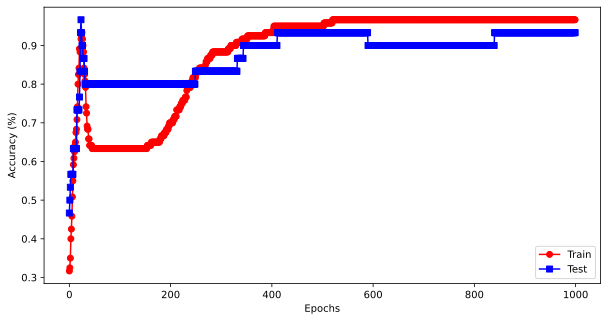

In [20]:
# Visualize the results
fig = plt.figure(figsize=(10, 5))

plt.plot(accuracies_train.detach(), "ro-")
plt.plot(accuracies_test.detach(), "bs-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.show()

#### Perform Experiment

In [21]:
train_sizes = torch.linspace(0.5, 0.95, 10)
accuracies_train, accuracies_test = (
    torch.zeros(size=(train_sizes.shape[0], 1)),
    torch.zeros(size=(train_sizes.shape[0], 1)),
)

for idx, tr_size in enumerate(train_sizes):
    train_acc, test_acc = train_model(train_size=tr_size)
    accuracies_train[idx] = torch.mean(train_acc)
    accuracies_test[idx] = torch.mean(test_acc)

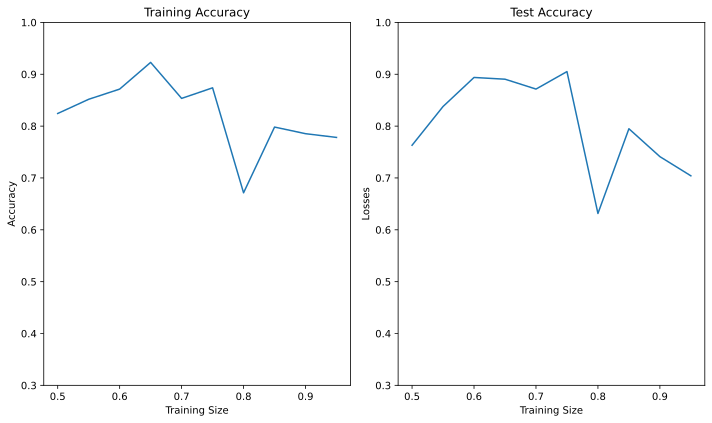

In [22]:
_, axs = plt.subplots(1, 2, figsize=(10, 6))
lower, upper = (0.3, 1)

axs[0].plot(train_sizes, accuracies_train.detach())
axs[0].set(xlabel="Training Size", ylabel="Accuracy", title="Training Accuracy")
axs[0].set_ylim(lower, upper)

axs[1].plot(train_sizes, accuracies_test.detach())
axs[1].set(xlabel="Training Size", ylabel="Losses", title="Test Accuracy")
axs[1].set_ylim(lower, upper)

plt.tight_layout()
plt.show()

In [23]:
torch.linspace(0.5, 0.95, 10)

tensor([0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500, 0.9000,
        0.9500])